#**Data Privacy: Computer Homework 01**


Sharif Univesity of  Technology - EE dept.

by Prof. Yassaee, Fall 2023

Contact *@danialayati* if you have any questions.

*Release Date:* 7 Azar 1402

*Soft Deadline:* 21 Azar 1402 - 23:55

*Hard Deadline:* 25 Azar 1402 - 23:55



---



# *Question 1*: In this question we want to demonstrate membership inference attacks on means by test statistics



First, tuneable simulation parameters:

In [1]:
import numpy as np
from scipy import stats
import math
np.random.seed(123)

n_sim = 1000
n_sample = 10
k_att = 100


Then, define utility functions for simulating data and calculating the test statistics:


In [2]:
def synthesize(pop_prob, n = 1):
  x = np.random.binomial(n = 1, p = pop_prob, size = (n, len(pop_prob)))
  return x

def test_homer(s, sample_mean, pop_mean):
  test_stat = sum(abs(s - pop_mean) - abs(s - sample_mean))
  return test_stat

def test_dwork(s, sample_mean, pop_mean):
    test_stat = sum((s - pop_mean) * (sample_mean - pop_mean) )
    return test_stat

def null_dist(function, pop_prob, pop_mean, null_sims=1000, alpha=0.05) :
    h = []
    for _ in range(null_sims):
        sample_mean = synthesize(pop_prob, n_sample).mean(axis=0)
        null_s = synthesize(pop_prob)[0]
        h.append(function(null_s, sample_mean, pop_mean))

    null_dist_values = np.sort(h)[::-1]
    critical_value = null_dist_values[round(alpha * null_sims)]
    return {
        "null_dist_values": null_dist_values,
        "critical_value": null_dist_values[round(alpha * null_sims)]
    }

Create Simple graph function for showing the distribution, partitioned by critical value, then Simulate and graph a null distribution:

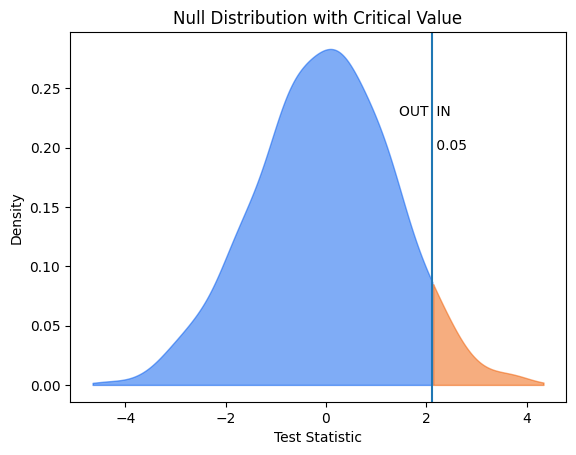

In [3]:
import matplotlib.pyplot as plt

def show_distribution(t_stats, critical_value, title) :
    # Create gaussian KDE and support points
    kernel = stats.gaussian_kde(t_stats)
    support = np.linspace(min(t_stats) - kernel.factor, max(t_stats) + kernel.factor, num=500)
    densities = kernel(support)
    # Flag critical value bound
    flag = support < critical_value
    max_density = max(densities)

    plt.fill_between(support[flag], densities[flag], color='#005aef80')
    plt.fill_between(support[~flag], densities[~flag], color='#ef5c0080')

    plt.axvline(x=critical_value)
    plt.text(x=critical_value, y=0.8*max_density, s=" IN", horizontalalignment='left')
    plt.text(x=critical_value, y=0.8*max_density, s="OUT ", horizontalalignment='right')
    plt.text(x=critical_value, y=0.7*max_density, s=f' {(t_stats > critical_value).mean():.2}', horizontalalignment='left')

    plt.title(title)
    plt.xlabel("Test Statistic")
    plt.ylabel("Density")
    plt.show()

# Generate random probabilities for the population
pop_prob = np.random.uniform(size = k_att)
pop_mean = pop_prob

# Find the null distribution
dist = null_dist(test_homer, pop_prob, pop_mean)
dist_values = dist["null_dist_values"]
critical_value = dist["critical_value"]
show_distribution(dist_values, critical_value, title="Null Distribution with Critical Value")
plt.show()

Now create a complete simulation of attack. We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

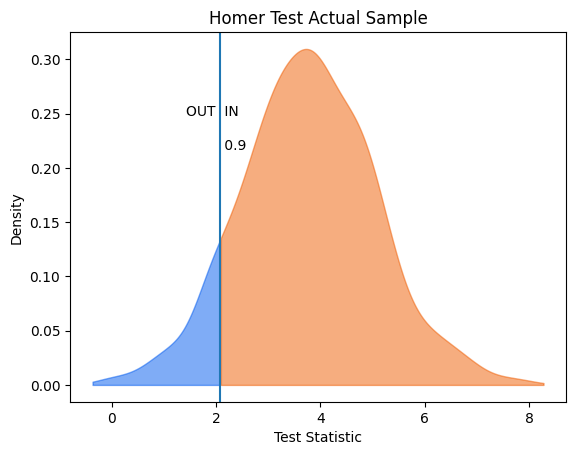

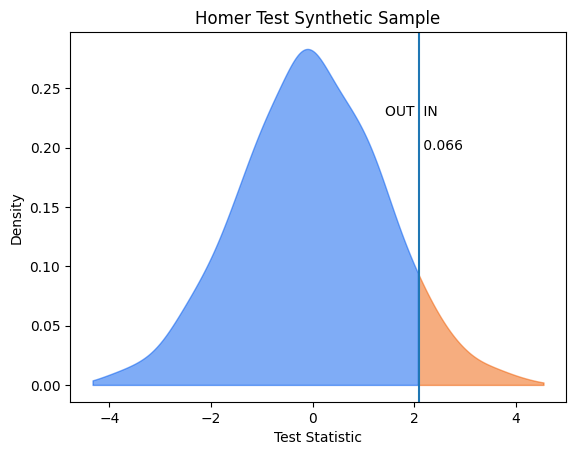

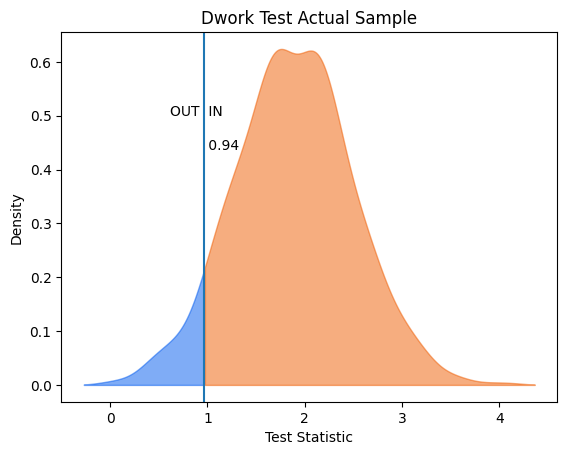

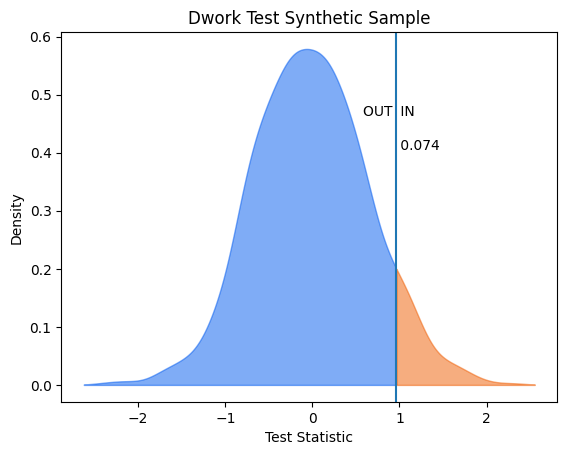

In [45]:
import numpy as np

history = np.zeros(shape=(n_sim, 4))
alpha = 0.05
# Generate null distributions
homer_dist = null_dist(test_homer, pop_prob, pop_mean, alpha = alpha)
dwork_dist = null_dist(test_dwork, pop_prob, pop_mean, alpha = alpha)

for i in range(n_sim):
    # Generate sample
    sample = synthesize(pop_prob, n_sample)
    sample_mean = sample.mean(axis=0)
    s = sample[0]
    null_s = synthesize(pop_prob)[0]
    # Store test results in history
    history[i, :] = [
        test_homer(s, sample_mean, pop_mean),
        test_homer(null_s, sample_mean, pop_mean),
        test_dwork(s, sample_mean, pop_mean),
        test_dwork(null_s, sample_mean, pop_mean)
    ]

# Plot
show_distribution(history[:, 0], homer_dist["critical_value"], "Homer Test Actual Sample")
show_distribution(history[:, 1], homer_dist["critical_value"], "Homer Test Synthetic Sample")
show_distribution(history[:, 2], dwork_dist["critical_value"], "Dwork Test Actual Sample")
show_distribution(history[:, 3], dwork_dist["critical_value"], "Dwork Test Synthetic Sample")




---



# *Question 2:* Now Let's bulid  Laplace Mechanism for Differential Privacy

First, construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [49]:
import numpy as np

def random_laplace_sampler(n, eps, delta, lc) :
  return np.random.laplace(loc=lc, scale=delta/eps, size=n)

def clamp(x, lower, upper) :
  return np.clip(x, lower, upper)


def release_dp_mean(x, epsilon, lower, upper):
    n = len(x)
    sensitivity = (upper-lower)/n
    scale = sensitivity/epsilon
    sensitive_answer = bounded_mean(x, bounds)
    dp_mean = sensitive_answer + laplace(shift=0., scale=scale)
    return dp_mean

def bounded_mean(x, lower, upper) :
  y = clamp(x, lower, upper)
  return np.mean(clamp(x, lower, upper))


Read in the data.  We're going to use the PUMS dataset, and focus on the education variable, a 16 point scale:

In [50]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")
educ = data['educ'].values.astype(float)


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using. After that,  call your privacy-preserving histogram.

In [52]:
import matplotlib.pyplot as plt

# Counting function
def range_query(df, col, a, b):
  return len(df[(df[col] >= a) & (df[col] < b)])

def dp_histogram(epsilon, df = data, col = 'educ', bins = list(range(1, 17))) :
  counts = [range_query(df, col, b, b+1) for b in bins]
  sensitivity = 1
  scale = sensitivity/epsilon
  dp_his = [(c + np.random.laplace(loc = 0.0, scale = scale)) for c in counts]
  return dp_his

# Example for epsilon = 2
display(dp_histogram(epsilon = 2))

[272.48605405537774,
 141.2454956195675,
 356.07143475609496,
 468.4274486547026,
 496.83729698165985,
 756.5076662289914,
 893.7063547346517,
 1060.0433139004244,
 5147.978030420957,
 1396.0302558407323,
 3962.9911472269114,
 1155.0617727616523,
 6283.930539753297,
 2269.838912463283,
 794.6098915533435,
 308.7643200028755]

Now we want to to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable. We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [10]:
def bootstrap(data, sample_size = 1000) :
    n = len(data)
    bootstrap_samples = []
    indices = np.random.randint(0, n, sample_size)
    bootstrap_sample = data[indices]
    return bootstrap_sample

eps_seq = np.random.rand(10)
ds_size = np.random.randint(1, 3000, size = 10)
dp_means = []
data_frame = []

for n in ds_size :
  for e in eps_seq :
    d = bootstrap(educ, n)
    mean = true_mean(d)
    dp_mean = release_dp_mean(d, e, 1, 16)
    err = (dp_mean - mean)**2
    data_frame.append([n, e, mean, dp_mean, err])

data_frame = pd.DataFrame(data_frame, columns=["Sample Size", "Epsilon", "Mean", "DP Mean", "Error"])
display(data_frame)

,Sample Size,Epsilon,Mean,DP Mean,Error
0,2471,0.346703,10.662890,[10.70495561417723],[0.0017695564127950456]
1,2471,0.083053,10.598543,[10.353193744984466],[0.06019630598667977]
2,2471,0.276483,10.558074,[10.580145467831539],[0.0004871649485568344]
3,2471,0.625914,10.693242,[10.677071351455018],[0.0002614770217698209]
4,2471,0.275223,10.582355,[10.59008503472128],[5.97484628952081e-05]
...,...,...,...,...,...
95,1056,0.360557,10.679924,[10.716761907232055],[0.001357013548492754]
96,1056,0.968595,10.556818,[10.57518549445909],[0.00033735817364886965]
97,1056,0.721079,10.685606,[10.6560174981656],[0.0008754830272930487]
98,1056,0.691299,10.636364,[10.635066941228379],[1.6814182738011505e-06]


Now graph your resluts!

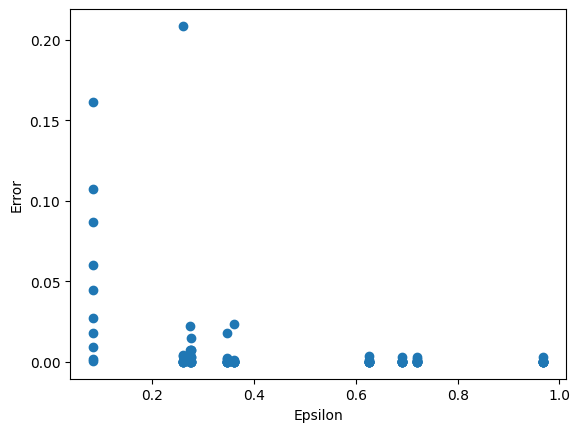

In [16]:
plt.plot(data_frame['Epsilon'], data_frame['Error'], 'o')
plt.xlabel("Epsilon")
plt.ylabel("Error")
plt.show()



---



# *Question 3:* OPENDP

The OpenDP Project is a community effort to build trustworthy, open source software tools for analysis of private data. The core software of the OpenDP Project is the OpenDP Library.

The OpenDP Library is a modular collection of statistical algorithms that adhere to differential privacy. The library is based on a conceptual framework described in [A Programming Framework for OpenDP](https://projects.iq.harvard.edu/files/opendp/files/opendp_programming_framework_11may2020_1_01.pdf).

The OpenDP Library can be found on GitHub: https://github.com/opendp/opendp/

OpenDP represents computations with Transformations and Measurements. First, recall all you need from opendp, then create a measurement that simply addds laplace noise and like a function.

In [54]:
!#pip install opendp
from opendp.measurements import *
from opendp.domains import atom_domain, vector_domain
from opendp.metrics import absolute_distance, symmetric_distance
from opendp.mod import *
from opendp.transformations import *
enable_features("contrib", "floating-point")

# call the constructor to produce the measurement `base_lap`
scale = .5
base_laplace: Measurement = make_base_laplace(atom_domain(T=float), absolute_distance(T=float), scale = scale)


# Example as a function
print(base_laplace(arg=5.))

lower = 1.
upper = 16.
sized_bounded_mean: Transformation = make_mean(input_domain = vector_domain(atom_domain((lower, upper)), educ.size),
                                               input_metric = symmetric_distance())
print(sized_bounded_mean(arg=educ))

4.166132378324753
10.608553908251183


We can also chain transformations and measurements. You might already think of chaining as function composition. The reason why we call it "chaining," instead of "composition," is because composition has a special meaning in differential privacy. In the context of differential privacy, composition refers to the joint release of more than one measurement.

In [18]:
# chain with the base_laplace measurement
dp_mean: Measurement = sized_bounded_mean >> base_laplace

# release a dp mean
dp_mean(arg=educ)

10.48118882820885

Now that we've shown how to build up computations and execute them, lets talk about distances.

Transformations and Measurements relate distances. There are three kinds of distances:

1. Dataset distances  
    (greatest distance between neighboring datasets)
1. Sensitivities  
    (greatest distance between queries on neighboring datasets)
1. Privacy budget    
    (greatest distance between the probability distributions)

The following shows how the `base_laplace` measurement relates a `sensitivity` to a privacy budget, `epsilon`.

In [19]:
# Check that when sensitivity is 0.15, the privacy usage is .30
base_laplace.check(d_in=.15, d_out=.30)

True

We can interpret this as: If the sensitivity is .15, then we could release the query answer with `laplace(scale=.5)` noise at a privacy expenditure of `.3 epsilon`. Equivalently, this data release is `.3 differentially private`, or `.3-DP`, where the privacy units are implicitly in terms of epsilon.

If we were to increase the sensitivity, the same relation would fail, and the release would not be `.3-DP`.

In [23]:
print("Checking for sensitivity .16 and privacy budget .30:")
print(base_laplace.check(d_in=0.16, d_out=0.30))

print("Checking for sensitivity .15 and privacy budget .29:")
print(base_laplace.check(d_in=.15, d_out=.29))

Checking for sensitivity .16 and privacy budget .30:
False
Checking for sensitivity .15 and privacy budget .29:
False


As you might expect, the relation will also pass for any sensitivity that is smaller, or any privacy expenditure that is larger. And similarly, the `sized_bounded_mean` transformation relates a dataset distance `max_influence` to a `sensitivity`.

In [30]:
print("Checking for sensitivity .15 and privacy budget .31:")
print(base_laplace.check(d_in=0.15, d_out=0.31))

print("Checking for sensitivity .14 and privacy budget .30:")
print(base_laplace.check(d_in=0.14, d_out=0.30))

Checking for sensitivity .15 and privacy budget .31:
True
Checking for sensitivity .14 and privacy budget .30:
True


Now relate distances on chained computations. The units for the input and output distances come from the constituent transformations and measurements.

For example, when we chain the `sized_bounded_mean` transformation and `base_laplace` measurement together, the input distance is a dataset distance, `max_influence`, and the output distance is measured in terms of a privacy budget, `epsilon`.

In [32]:
print(dp_mean.check(d_in=1, d_out=0.5))

True


# *Question 4:* Gaussian Mechanism

Let's extend the basic building blocks to include a Gaussian mechanism and a random sampler from the Gaussian.

In [33]:
import numpy as np


def gauss_release_dp_mean(x, epsilon, lower, upper):
  n = len(x)
  loc = bounded_mean(x, lower, upper)
  # scince we have one element, L1 and L2 norms are equal
  sensitivity = (upper-lower)/n
  return random_gauss_sampler(1, epsilon, sensitivity, loc)

Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale.

In [38]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")
educ = data['educ'].values.astype(float)


Now simulate repeated draws from both mechanisms to compare the utility they offer over a range of epsilon values and dataset sizes.  

In [42]:
def random_gauss_sampler(n, eps, delta, lc) :
  return np.random.normal(loc=lc, scale=delta/eps, size=n)


eps_seq = np.random.rand(10)
ds_size = np.random.randint(1, 3000, size = 10)
dp_means = []
data_frame = []

for n in ds_size :
  for e in eps_seq :
    d = bootstrap(educ, n)
    mean = true_mean(d)
    laplace_dp_mean = release_dp_mean(d, e, 1, 16)
    gauss_dp_mean = gauss_release_dp_mean(d, e, 1, 16)
    # Err from laplace dp mean
    err_l = (laplace_dp_mean - mean)**2
    # Err from gaussian dp mean
    err_g = (gauss_dp_mean - mean)**2
    data_frame.append([n, e, err_l, err_g])

data_frame = pd.DataFrame(data_frame, columns=["Sample Size", "Epsilon", "Laplace Err", "Gaussian Err"])
display(data_frame)

,Sample Size,Epsilon,Laplace Err,Gaussian Err
0,1760,0.447104,[0.0011258321100739758],[4.816064830445833e-05]
1,1760,0.564018,[0.0006649931541543589],[0.0006396821536369143]
2,1760,0.398948,[0.0005715781392021112],[0.0005212673281584553]
3,1760,0.450834,[0.0017952772802170616],[0.00011574802396068316]
4,1760,0.490092,[0.00011651430878384936],[2.188252536393106e-07]
...,...,...,...,...
95,2553,0.638603,[0.00012519025593828214],[4.3208707040565707e-05]
96,2553,0.792713,[9.610075673481075e-06],[1.2963447464117889e-05]
97,2553,0.012789,[0.7665625436767046],[0.014308577920244894]
98,2553,0.762809,[3.3857644397516173e-05],[0.00015565633332592996]


And Finally Graph your result:

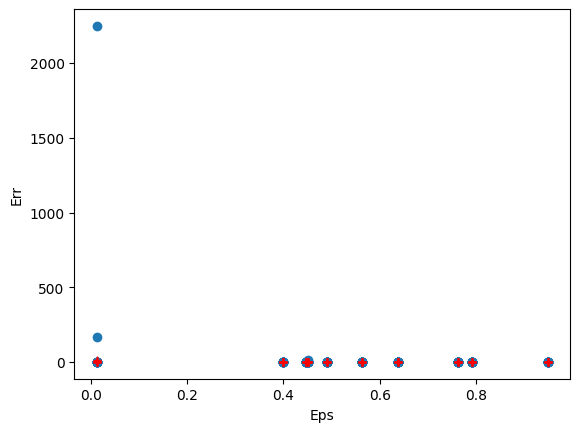

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# data for plotting
t = data_frame['Epsilon']
s = data_frame['Laplace Err']
r = data_frame['Gaussian Err']
plt.plot(t, s, 'o')
plt.plot(t, r, 'r+')
plt.xlabel("Eps")
plt.ylabel("Err")
plt.show()